# Random Forest

## Data Preprocessing

In [15]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Set working directory
month_file = '3_July'
# Set working directory
os.chdir("/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/"+month_file+"/Ending Balances/Per_Player")

In [16]:
# Load original dataset
dataset = pd.read_parquet('per_player_ending_balance_by_session.parquet')

print(dataset.columns)

Index(['playerkey', 'session_time', 'rank', 'gender', 'age_range', 'age_gen',
       'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom',
       'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
       'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
       'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit',
       'depletion_slope', '#inc_maxbet', '#dec_maxbet', 'first_wager',
       'first_outcome', 'first_p/b', 'last_wager', 'last_outcome', 'last_p/b',
       '#W', '#L', '#NH', '#D', 'w/min', 'l/min', 'nh/min', 'd/min', 'w/g',
       'l/g', 'nh/g', 'd/g', '#2ws', '2ws_profit', '2ws_wgramt', '#3ws',
       '3ws_profit', '3ws_wgramt', '#4ws', '4ws_profit', '4ws_wgramt',
       '2ws/min', '3ws/min', '4ws/min', 'ave_time_per_gamble',
       'std_time_per_gamble', 'min_time_per_gamble', 'max_time_per_gamble',
       'total_duration', 'total_gambles', 'machines_changes', '#inc_slotdenom',
       '#dec_slotdenom'

## Load Dataframes

In [17]:
# Filter Columns
filter = ['session_time', 'gender',  'sim_play', 'age_gen', 'first_outcome',
        'first_wager','first_p/b', 'last_outcome', 'last_wager', 'last_p/b',
        'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom', 
        'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
        'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
        'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit', 'depletion_slope', 
        '#inc_slotdenom', '#dec_slotdenom', '#inc_maxbet', '#dec_maxbet', 
        'w/min', 'l/min', '2ws/min', '3ws/min', '4ws/min',
        'nh/min', 'd/min', 'w/g', 'l/g', 'nh/g', 'd/g', 'ave_time_per_gamble',
        'std_time_per_gamble', 'min_time_per_gamble', 'max_time_per_gamble',
        'machines_changes', 'unique_machines', 'percentile']

# Columns NOT INCLUDED
# 'playerkey', 'rank', 'age_range', '#W', '#L', '#NH', '#D', #2ws, #3ws, #4ws, 2ws_profit, 3ws_profit, 4ws_profit,
# 2ws_wgramt, 3ws_wgramt, 4ws_wgramt, ave_time_per_machine, 'total_duration', 'total_gambles'

# Load dataset
dataset = pd.read_parquet('per_player_ending_balance_by_session.parquet', columns=filter)

# Keep only session_time 1
dataset = dataset[dataset['session_time'] == 1]
# Drop age_range and playerkey
dataset = dataset.drop(['session_time'], axis=1)


# # Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

## Taking Care of Missing Data

X[:, 3:31] it covers from beggining account balance to 4ws_wgramt column

We do not need this step since we do not have missing data!

In [18]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# imputer.fit(X[:, 3:31])
# X[:, 3:31] = imputer.transform(X[:, 3:31])

## Encoding Categorical Data

### Encoding the Independent Variable

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Econde gender column (Binary)
le = LabelEncoder()

# Binary Encode gender and simplay
X[:, 0] = le.fit_transform(X[:, 0])
X[:, 1] = le.fit_transform(X[:, 1])

In [20]:
# # Encode age_generartion, first_outoce, last_outcome columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2, 3, 6])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

### Encoding the Dependent Variable

In [21]:
y = le.fit_transform(y)

## Splitting the dataset into the Training set and Test set

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Scale all columns except the encoded ones
X_train[:, 14:] = sc.fit_transform(X_train[:, 14:])
X_test[:, 14:] = sc.transform(X_test[:, 14:])

## Training the Logistic Regression model on 

1.   X_train
2.   y_train

the Training set

In [24]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Which IDVs have the most weight in the model

In [25]:
from sklearn.inspection import permutation_importance

# Assuming you have a trained classifier named 'classifier' and encoded data named 'X_encoded'
# Calculate permutation importances
result = permutation_importance(classifier, X_train, y_train, n_repeats=10, random_state=42)

# Get feature importances and feature names
importances = result.importances_mean
feature_names = ct.get_feature_names_out()

# Sort feature importances
feature_importance = list(zip(feature_names, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Print feature importances
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")


remainder__x25: 0.02078964978808835
remainder__x46: 0.005175105955833148
remainder__x48: 0.004684363149676551
remainder__x26: 0.0045951371849208165
remainder__x38: 0.0038813294668748723
remainder__x32: 0.003234441222395723
remainder__x34: 0.0028552308721838116
remainder__x23: 0.0027436984162391375
remainder__x42: 0.002453714030782961
remainder__x24: 0.0021637296453268064
remainder__x45: 0.002029890698193182
remainder__x9: 0.0020075842070042425
remainder__x31: 0.0019406647334374472
remainder__x40: 0.0018737452598706183
remainder__x27: 0.0018068257863038451
remainder__x33: 0.0015837608744144749
remainder__x47: 0.0015614543832255135
remainder__x39: 0.0014499219272808505
remainder__x10: 0.001383002453714044
remainder__x11: 0.001293776488958298
remainder__x43: 0.0012268570153915026
remainder__x37: 0.001159937541824696
remainder__x44: 0.0010037921035021436
remainder__x19: 0.0010037921035021325
remainder__x41: 0.0009145661387463977
remainder__x16: 0.0008253401739906519
remainder__x30: 0.00080

### Predicting the Test set results

In [26]:
y_pred = classifier.predict(X_test)

print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 0]
 [1 1]
 [1 1]]


### Making the Confusion Matrix and Accuracy Score

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

# Interpretation of confusion matrix
print('True Positive (B20): ', cm[0][0])
print('True Negative (T20): ', cm[1][1])
print('False Positive: ', cm[0][1])
print('False Negative: ', cm[1][0])

[[552   8]
 [ 22 539]]
Accuracy:  0.9732381801962533
Precision:  0.9853747714808044
Recall:  0.9607843137254902
F1 Score:  0.9729241877256318
True Positive (B20):  552
True Negative (T20):  539
False Positive:  8
False Negative:  22


## Cumulative Accuracy Profile (CAP) Graph

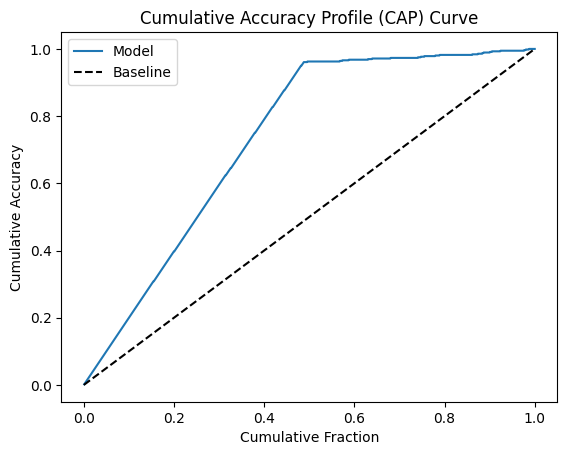

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred)[::-1]
sorted_true_labels = y_test[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_test)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')
plt.legend()
plt.show()